## ¿Qué problema se va a resolver?
El tema de investigación surgió por la necesidad que tienen las empresas operadoras de taxis de la ciudad de Bogotá, estas vienen presentando una creciente problemática de indisponibilidad de servicios de taxis en sus plataformas, esto suceso ocurre principalmente en algunas zonas u horarios específicos.
La empresa Taxis Libres (TL), una de las más grandes operadoras de servicios de taxis de la ciudad, ha empezado a recibir una gran cantidad de inconformidades por partes de los usuarios recurrentes de la plataforma por esta misma causa. Solo en el mes de mayo del 2022 la plataforma recibió alrededor de 1.2 millones de solicitudes de servicios de taxis de los cuales el 57% de esas solicitudes fueron abandonadas o rechazadas, lo que los llevó a analizar qué estaba pasando con la prestación de servicios internamente, en esa revisión realizada durante el mismo periodo de tiempo se obtuvieron las principales causas reportadas en la plataforma y que se listarán a continuación:

•	El usuario se fue

•	El vehículo se demoró en llegar

•	El usuario tomó otro taxi

Al identificar las causas de los servicios abandonados y rechazados, la empresa se planteó a resolver la siguiente pregunta al problema presentado.
¿Como reducir la alta cantidad de inconformidades de los usuarios recurrentes de la plataforma prediciendo sus comportamientos durante la semana y así programarles sus servicios de forma anticipada?

## Objetivo general
Diseñar un método para predecir las solicitudes de servicios de los usuarios recurrentes "de empresas de servicios de" taxis en la ciudad Bogotá - Colombia, "mediante" modelos de ML.


Evaluar el desempeño de modelos de ML para predecir
las solicitudes de servicios de los usuarios recurrentes de empresas de servicios de taxis en la ciudad Bogotá -  Colombia
basados en el comportamiento dentro de la plataforma.

## Objetivos específicos (Detallar las actividades)
• Revisar la literatura de al menos 10 artículos de proyectos relacionados (pendiente)

• Analizar los datos de los últimos 6 meses de servicios de la empresa taxis libres.

• Determinar las variables significativas a ser empleadas en los modelos de ML.

• Evaluar diferentes modelos de ML para la predicción de solicitudes.

## ¿Que solución propone al problema?
El diseño de un modelo predictivo de solicitudes de servicios de taxis basados en comportamientos de usuarios recurrentes de plataformas móviles para empresas de transporte

## ¿Cómo lo pretende solucionar?
Utilizando un modelo de clasificación donde se agrupe la información de los servicios que han tomado los usuarios por días de las semanas y horarios, determinando si en ese día y a esa hora se va a tomar un servicio.

## ¿Que resultados que espera obtener?
Se espera obtener listado por día de las semanas con todos los horarios del día y un determinador que indique si el servicio se va a tomar o no en ese horario. 

### Exploratory data analysis

Project library definition

In [635]:
#librerias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.multiclass import OneVsRestClassifier
#from sklearn.metrics import plot_confusion_matrix
from matplotlib.colors import ListedColormap
#from mlxtend.plotting import plot_decision_regions
#modelos
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron

#from sklearn.metrics import mean_absolute_error
#from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import cohen_kappa_score

import numpy as np
#from numpy import NaN
from datetime import datetime, timedelta
#from os import name
import math

The initial parameters are defined

In [636]:
TRAIN_WEEK = 6.0
TEST_WEEK = 1.0
BOGOTA_CODE = 11001
HOURS_OF_DAY = 24
DAYS_OF_WINDOWS = 6
WEEKS_RECURRENT = 4
FORMAT_DATE = '%Y-%m-%d'
FORMAT_COMPLETE_DATE = '%Y-%m-%d %H:%M:%S'
DATE_START_TRAINIG = pd.to_datetime("2023-03-10", format=FORMAT_DATE)
FICHERO_DATA = '../data/SERVICIO_UNIFICADO_2023.parquet.gzip'

#Se obtiene la fecha de inicial de entrenamiento
last_date_dataset = DATE_START_TRAINIG - timedelta(weeks=TRAIN_WEEK)
#Se obtiene la fecha de inicial de entrenamiento
first_date_dataset = DATE_START_TRAINIG + timedelta(weeks=TEST_WEEK)


The data is loaded into the dataFrame

In [637]:
#Se lee el archivo de un parquet a un dataframe
df_taxis = pd.read_parquet(FICHERO_DATA) 
#Se visualizan los datos
print(f"({len(df_taxis):,}) records were loaded into dataset!")

(16,511,429) records were loaded into dataset!


The data types of the dataset are displayed

In [638]:
df_taxis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16511429 entries, 0 to 16511428
Data columns (total 14 columns):
 #   Column         Dtype  
---  ------         -----  
 0   ID             int64  
 1   CITY           int64  
 2   USER           float64
 3   LATITUDEORI    float64
 4   LATITUDEDEST   float64
 5   LONGITUDEORI   float64
 6   LONGITUDEDEST  float64
 7   STATUS         object 
 8   CHANNEL        object 
 9   COMPLETEDATE   object 
 10  DATE           object 
 11  DAYOFWEEK      int64  
 12  HOUR           int64  
 13  MONTH          int64  
dtypes: float64(5), int64(5), object(4)
memory usage: 1.7+ GB


Validates how many null values are present in the dataset

In [639]:
df_taxis.isnull().sum()

ID                     0
CITY                   0
USER                 184
LATITUDEORI            0
LATITUDEDEST     3495636
LONGITUDEORI           0
LONGITUDEDEST    3495636
STATUS                 0
CHANNEL                0
COMPLETEDATE           0
DATE                   0
DAYOFWEEK              0
HOUR                   0
MONTH                  0
dtype: int64

Data is cleaned where the user is null

In [640]:
df_taxis = df_taxis[~df_taxis['USER'].isnull()]

Dataset fields are displayed

In [641]:
df_taxis.head(5)

,ID,CITY,USER,LATITUDEORI,LATITUDEDEST,LONGITUDEORI,LONGITUDEDEST,STATUS,CHANNEL,COMPLETEDATE,DATE,DAYOFWEEK,HOUR,MONTH
0,80206465,11001,8168434.0,4.646835,4.669337,-74.101619,-74.111349,CANCELADO,APP,2022-10-01 00:00:00,2022-10-01,6,0,10
1,80206466,11001,8692306.0,4.648861,NaN,-74.109828,NaN,ABANDONADO,APP,2022-10-01 00:00:00,2022-10-01,6,0,10
2,80206467,11001,10186684.0,4.607889,4.547080,-74.078844,-74.148150,ABANDONADO,APP,2022-10-01 00:00:00,2022-10-01,6,0,10
3,80206468,17001,10171299.0,5.052368,NaN,-75.480895,NaN,ABANDONADO,CHAT_BOT_659,2022-10-01 00:00:00,2022-10-01,6,0,10
4,80206469,17001,10244322.0,5.045227,NaN,-75.517250,NaN,ABANDONADO,CHAT_BOT_659,2022-10-01 00:00:00,2022-10-01,6,0,10


## Display of initial data

The number of services in a period of time is displayed

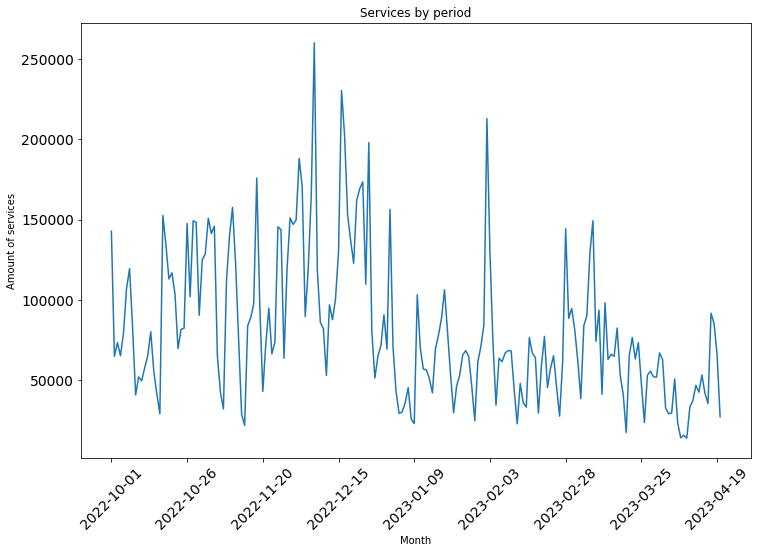

In [642]:
df_taxis.groupby(['DATE'])['ID'].count().plot(kind='line',stacked=True, fontsize=14, xlabel="Month", ylabel="Amount of services", figsize=(12,8), title="Services by period", rot=45)
plt.show()

The number of services per state per month is displayed

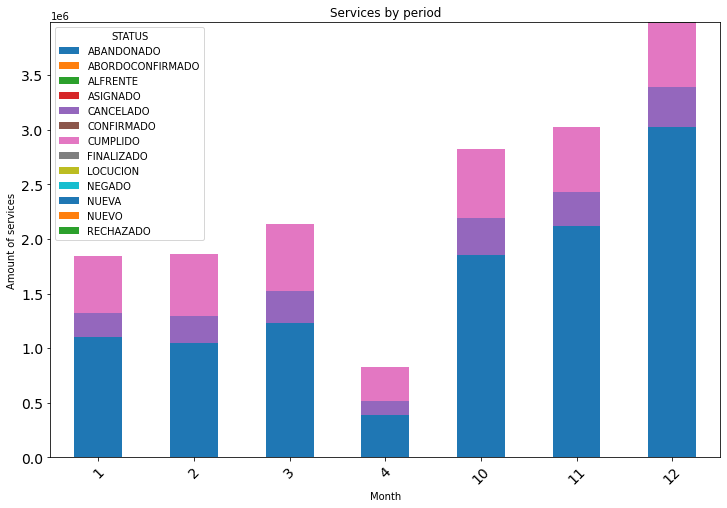

In [643]:
df_taxis.groupby(['MONTH','STATUS'])['ID'].count().unstack('STATUS').plot(kind='bar',stacked=True, fontsize=14, xlabel="Month", ylabel="Amount of services", figsize=(12,8), title="Services by period", rot=45)
plt.show()

## Display of filtered data

The dataset is filtered with the values to be used: 6 weeks for training and 1 week for the test

In [644]:
df_taxis = df_taxis[ (pd.to_datetime(df_taxis['COMPLETEDATE'], format=FORMAT_DATE) >= last_date_dataset) & (pd.to_datetime(df_taxis['COMPLETEDATE'], format=FORMAT_DATE) <= first_date_dataset) ]
df_taxis = df_taxis.sort_values(by=['COMPLETEDATE','USER'])
print(f"The dataset is restricted from date:{last_date_dataset} - to date:{first_date_dataset}")

The categorical data of channel is displayed

In [ ]:
#Se visualiza la cantidad por origen
plt.figure(figsize=(12,8))
sns.histplot(df_taxis['CHANNEL'])
plt.xticks(rotation='vertical')
plt.show()

The categorical data of status is displayed

In [ ]:
#Se visualiza la cantidad de servicios por estado
plt.figure(figsize=(12,8))
sns.histplot(df_taxis['STATUS'])
plt.xticks(rotation='vertical')
plt.show()

DataFrame data is displayed in a histogram to analyze the data

In [ ]:
df_taxis.hist(figsize=(20,10))
plt.show()

The number of services per channel per state is displayed

In [ ]:
df_taxis.groupby(['CHANNEL','STATUS'])['ID'].count().unstack('STATUS').plot(kind='bar',stacked=True, fontsize=14, xlabel="Month", ylabel="Amount of services", figsize=(12,8), title="Services by period", rot=45)
plt.show()

In [ ]:
#TODO: delete this block
df_taxis.groupby(['DATE','DAYOFWEEK'])['USER'].count()

- Channels are limited to: APP, RECEPCION, CHAT_BOT_659, IVR and CALLE

- States are limited to: ABANDONADO, CUMPLIDO, CANCELADO and FINALIZADO

In [ ]:
df_taxis = df_taxis[(df_taxis["CHANNEL"]=="APP") ]#| (df_taxis["CHANNEL"]=="RECEPCION") | (df_taxis["CHANNEL"]=="CHAT_BOT_659") | (df_taxis["CHANNEL"]=="IVR") | (df_taxis["CHANNEL"]=="CALLE")]
df_taxis = df_taxis[(df_taxis["STATUS"]=="ABANDONADO") | (df_taxis["STATUS"]=="CUMPLIDO") | (df_taxis["STATUS"]=="CANCELADO") | (df_taxis["STATUS"]=="FINALIZADO")]

Correlations between variables are displayed

In [ ]:
plt.figure(figsize=(12,8))
sns.heatmap(df_taxis.corr(method='pearson'),annot=True)
plt.show()

A histogram is displayed with the number of services per state

In [ ]:
df_taxis.groupby(['MONTH','STATUS'])['ID'].count().unstack('STATUS').plot(kind='bar',stacked=True, fontsize=14, xlabel="Month", ylabel="Amount of services", figsize=(12,8), title="Services by period", rot=0)
plt.show()

The number of services per status is displayed

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
s_taxis = df_taxis.groupby(['STATUS','HOUR'])['DATE'].count()
s_taxis.plot(ax=ax)
_ = ax.set(
    title="Number of services per status",
    xticks=[i * 24 for i in range(4)],
    xticklabels=["ABANDONADO", "CANCELADO", "CUMPLIDO", "FINALIZADO"],
    xlabel="Status per hour",
    ylabel="Amount of services",
)

Columns that are not useful for the model are deleted and reindex the data frame

In [ ]:
df_taxis = df_taxis.drop(columns=["CITY","ID","LATITUDEDEST","LONGITUDEDEST","LATITUDEORI","LONGITUDEORI","COMPLETEDATE","CHANNEL","STATUS","MONTH"])
#Duplicate values are removed from the dataframe and sorted by the most relevant fields
df_taxis = df_taxis.drop_duplicates().sort_values(by=['DATE','USER','DAYOFWEEK','HOUR'])
#The data frame is reindexed again
df_taxis = df_taxis.reset_index(drop=True)
#The data frame is displayed
df_taxis.head(5)

Se eliminan los usuarios no recurrentes del dataset (Usuarios recurrentes: son aquellos que tomaron al menos 1 servicio semanal durante almenos 4 semanas anteriores)

The number of services per week is displayed

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
s_taxis = df_taxis.groupby(['DAYOFWEEK','HOUR'])['DATE'].count()
s_taxis.plot(ax=ax)
_ = ax.set(
    title="Number of services per week",
    xticks=[i * 24 for i in range(7)],
    xticklabels=["Sun", "Mon", "Tue", "Wed", "Thr", "Fri", "Sat"],
    xlabel="Day of week",
    ylabel="Amount of services",
)

The number of services per hour is displayed

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
s_taxis = df_taxis.groupby(['HOUR'])['DATE'].count()
s_taxis.plot(ax=ax)
_ = ax.set(
    title="Number of services per hour",
    xticks=[i for i in range(24)],
    xticklabels=[i for i in range(24)],
    xlabel="Hour of day",
    ylabel="Amount of services",
)

The number of services assigned to a user is counted after eliminating duplicates

In [ ]:
count_services = df_taxis.loc[:,['USER']].value_counts()
count_services

The distribution of the data is displayed

In [ ]:
#Se visualizan los valores de los datos
count_services.describe()

The number of outliers in the dataset is calculated

In [ ]:
#The 25th quartile is calculated
q25 = count_services.quantile(0.25)
#The 50th quartile is calculated
q50 = count_services.quantile(0.5)
#The 75th quartile is calculated
q75 = count_services.quantile(0.75)
#The  max value is calculated
max_val = count_services.max()
#The inter-quartile range is calculated
iqr = q75 - q25

print(f"El porcentaje del quartil 25: {q25}")
print(f"El porcentaje del quartil 75: {q75}")
print(f"El porcentaje del máximo: {max_val}")
print(f"El rango inter quartil es: {iqr}")

Calculation of the outlier threshold

In [ ]:
outliers_threshold = ( q75 + 3 * iqr )
print(f"El umbral de los valores atípicos es: {outliers_threshold}")
print(f"La cantidad de valores atípicos son: {sum(count_services > outliers_threshold) }")

Outliers are removed from the dataset

In [ ]:
df_taxis = df_taxis.groupby('USER').filter(lambda x: (x['USER'].count() > outliers_threshold) )

Se Validan los datos del dataset

In [ ]:
count_services = df_taxis.loc[:,['USER']].value_counts()
count_services

### DATA VISUALIZATION

* Gráfico de dispersión de las variables
* Gráfico de distribución de las variables (Baja distribución, Baja predicción)
* Gráficas de correlación (Mapa de calor)

In [ ]:
#Se presenta un gráfico general de los datos
sns.pairplot(df_taxis, height=4)
plt.show()

The correlation matrix is displayed

In [ ]:
corr_matrix = df_taxis.corr()
corr_matrix

The relationship between variables in the data are displayed

In [ ]:
f, ax = plt.subplots(figsize=(12, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr_matrix, annot=True, mask = mask, cmap=cmap )
plt.title('Relationship between dataframe variables',fontsize=20,fontname='serif')
plt.ylabel('Y', color='green', fontsize=25)
plt.xlabel('X', color='Red', fontsize=25)

In [ ]:
#limites de decision
def make_meshgrid(X, step=.02):
    x = X.iloc[:,0].values
    y = X.iloc[:,1].values
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))
    return xx, yy

def plot_contours(ax, clf, X, y, **params):

    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'cyan', 'gray')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    xx, yy = make_meshgrid(X)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())

    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        Z[Z == cl] = idx
        ax.scatter(X.loc[y == cl, X.columns[0]], 
                    X.loc[y == cl, X.columns[1]],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx],
                    label=cl, 
                    edgecolor='black',
                    cmap=cmap,
                    s=50)
    
    ax.legend()
    ax.set_ylabel(X.columns[1])
    ax.set_xlabel(X.columns[0])
    ax.set_title(clf.__class__.__name__)
    ax.grid()    
    out = ax.contourf(xx, yy, Z, alpha=0.2, cmap=cmap)
    
    return out

In [ ]:
#ROC Y AUC
def ROC(X, y, model):

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

  clf = OneVsRestClassifier(model)
  clf.fit(X_train, y_train)
  pred = clf.predict(X_test)
  pred_prob = clf.predict_proba(X_test)
  pred_prob = np.nan_to_num(pred_prob)

  fpr = {}
  tpr = {}
  thresh ={}

  fig, ax = plt.subplots(figsize=(10,8))
  colors = ('orange', 'green', 'blue')
  
  for index, label_ in enumerate(y.unique()):
    fpr[label_], tpr[label_], thresh[label_] = roc_curve(y_test, pred_prob[:,index], pos_label=label_) 
    ax.plot(fpr[label_], tpr[label_], linestyle='--',color=colors[index], label=label_)
  
  ax.plot([0, 1], [0, 1], linestyle='--',color='red', label='No Skill')
  ax.set_title(f'Multiclass ROC curve -  {model.__class__.__name__}')
  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive rate')
  ax.grid(True)
  plt.show()

  return ax.legend(loc='best')

Function to train the model and predict with test values

In [ ]:
def predictModel(model, X_train, y_train, X_test):
    #A continuación se entrena el modelo
    model.fit(X_train, y_train)
    #Se crean las predicciones para pruebas
    y_pred = model.predict(X_test)
    #Se crean las probabilidades para pruebas
    y_prob = model.predict_proba(X_test)
    return model, y_pred, y_prob

Function that evaluate the K-neighbors model

In [ ]:
def knnModel(X_train, y_train, X_test):
    #Se aplica el modelo de K vecinos
    model = KNeighborsClassifier(n_neighbors=1, metric='euclidean',leaf_size=1, p=1, weights='uniform')
    return predictModel(model, X_train, y_train, X_test)

Function that evaluate the Multi-layer Perceptron model

In [ ]:
def mlpModel(X_train, y_train, X_test):
    #Se aplica el modelo de perceptrones multi capa
    model = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(30,30, 30), random_state=1,learning_rate_init=0.001,max_iter=5000)
    return predictModel(model, X_train, y_train, X_test)

Function that evaluate the Perceptron model

In [ ]:
def perModel(X_train, y_train, X_test):
    #Se aplica el modelo de perceptrones multi capa
    model = Perceptron(eta0=0.1, n_iter_no_change=10, random_state=1)
    return predictModel(model, X_train, y_train, X_test)

Function that evaluate the Logistic Regression model

In [ ]:
def lrModel(X_train, y_train, X_test):
    #Se aplica el modelo de de regesión logística
    model = LogisticRegression(random_state = 1)
    return predictModel(model, X_train, y_train, X_test)

Function that evaluate the Random Forest model

In [ ]:
def rfcModel(X_train, y_train, X_test):
    #Se aplica el modelo de los arboles aleatorios
    model = RandomForestClassifier(criterion='gini', max_depth=5, n_estimators=200, class_weight="balanced")
    return predictModel(model, X_train, y_train, X_test)

Function that evaluate the Support Vector Machine model

In [ ]:
def svcModel(X_train, y_train, X_test):
    #Se aplica el modelo de máquina de soporte de vectores
    model = SVC(kernel='rbf', random_state=1, gamma=0.2, C=1.0, class_weight='balanced')#, class_weight='balanced'
    return predictModel(model, X_train, y_train, X_test)

Function that evaluate the Decision Tree model

In [ ]:
def dtcModel(X_train, y_train, X_test):
    #Se aplica el modelo de los arboles de desiciones
    model = DecisionTreeClassifier(criterion='gini', max_depth=3, class_weight='balanced')#class_weight={0: 1, 1: 5}
    return predictModel(model, X_train, y_train, X_test)

Function that evaluate Extra Trees Classifier

In [ ]:
def etcModel(X_train, y_train, X_test):
    model = ExtraTreesClassifier(n_estimators=1, max_depth=1, min_samples_split=2, random_state=0, class_weight="balanced")
    return predictModel(model, X_train, y_train, X_test)

Function that evaluate Gradient Boosting Classifier, this function supports both binary and multi-class classification

In [ ]:
def gbcModel(X_train, y_train, X_test):
    model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0)
    return predictModel(model, X_train, y_train, X_test)

Function that evaluate Ada Boost

In [ ]:

def abcModel(X_train, y_train, X_test):
    model = AdaBoostClassifier(n_estimators=1,algorithm='SAMME',random_state=0)
    return predictModel(model, X_train, y_train, X_test)

Function that evaluate the Stochastic Gradient Descent model

In [ ]:
def sgdModel(X_train, y_train, X_test,):
    #Se aplica el modelo de gradiente descendente estocástico
    model =SGDClassifier(loss='huber', random_state=1, max_iter=2000, epsilon=0.1)#loss='hinge'
    return predictModel(model, X_train, y_train, X_test)

Function for displaying data visualization with subplots

In [ ]:
def dataVisualization(df_train):
    #Se visualiza los datos por columnas de entrenamiento
    fig, axes = plt.subplots(1, len(df_train.columns))
    fig.set_size_inches(21,6)
    for i, column in enumerate(df_train.columns):
        sns.histplot(df_train[column], kde=True, ax=axes[i])
    plt.show()

Function to display the confusion matrix

In [ ]:
def confusionMatrix(model, y_test, y_pred):
  '''
  plt.rcParams.update({'font.size': 16})
  fig, axes = plt.subplots(figsize=(14, 10))
  disp = ConfusionMatrixDisplay.from_estimator(model,
                                             y_test,
                                             y_pred,
                                             display_labels=model.classes_,
                                             cmap=plt.cm.Blues,
                                             ax=axes
                                             )
  disp.ax_.set_title(f'Confusion Matrix - {model.__class__.__name__}')
  plt.show()
  '''
  plt.rcParams.update({'font.size': 16})
  cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=model.classes_)
  disp.plot()
  plt.show()

In [ ]:
def contoursGrap(model, X, y):
    plt.rcParams.update({'font.size': 16})
    fig, axes = plt.subplots(figsize=(12, 10))
    plot_contours(axes, model, X, y, cmap=plt.cm.coolwarm, alpha=0.5)
    plt.show()

Function to display the different reports for comparing the models

In [ ]:
def reportClassification(model, X_train, y_train, y_pred, X_test, y_test, model_type):
    if model_type == 'LR':
        #Se imprimen los coeficientes, intresección y número de coeficientes
        print(f"Coeficientes del modelo: {model.coef_}\n")
        print(f"Intresección del modelo: {model.intercept_}\n")
        print(f"Número de coeficientes del modelo: {len(model.coef_)}\n")
    if model_type != 'PR':

        if (model_type != 'SVC') & (model_type != 'SGD'):
            #
            ROC(X_train, y_train, model)
        #
        contoursGrap(model, X_train, y_train)
        #
    #Se muestra la matriz de confusión
    confusionMatrix(model, y_test, y_pred)
    #Se imprime el reporte de clasificación
    #print(classification_report(y_test, y_pred))
    #mae = mean_absolute_error(y_test, y_pred)
    #print("MAE:",(mae))
    
    

Function to calculate a user's probability

In [ ]:
def ProbabilisticClassifier(hour, day, data):
  data_array = data.to_numpy()
  first = pd.to_datetime(data.tail(1).iloc[0,2], format=FORMAT_DATE)
  last = pd.to_datetime(data.head(1).iloc[0,2], format=FORMAT_DATE)
  remaining_days = first.date() - last.date()
  total = 0 
  for i in range(remaining_days.days):
    last_time = last + timedelta(days=i)
    if last_time.isoweekday() == day:
      total += 1
  total_onset = 0
  for row in data_array:
    #print(f" day({row[0]} == {day}) hour({row[1]} == {hour}) service({row[3]} == {1})")
    if( ( row[0] == day ) & ( row[1] == hour ) & ( row[3] == 1 ) ):
      total_onset += 1
  if total > 0:
    return total_onset / total
  else:
    return 0

Function to evaluate the probabilistic model

In [ ]:
def probabilisticModel(data, date_predict):
    threshold = 0.6
    array_result = []
    array_prob = []
    for hour in range(HOURS_OF_DAY):
        result = ProbabilisticClassifier(hour, date_predict.isoweekday(), data)
        array_prob.append(round(result,2) if result >= threshold else 0 )
        array_result.append(1 if result >= threshold else 0)
    return array_result, array_prob

Function to identify how many weeks a user took services

In [ ]:
def weeksWithServices(user, data, training_date):
    weeks = 0
    date_time = training_date
    for _ in range(int(TRAIN_WEEK)):
      first_time = pd.to_datetime(date_time, format=FORMAT_DATE)
      last_time = first_time + timedelta(weeks=-1)
      df_rec = data[ (data["USER"]==user) & (pd.to_datetime(data['DATE'], format=FORMAT_DATE) >= last_time) & (pd.to_datetime(data['DATE'], format=FORMAT_DATE) <= first_time) ]
      date_time = last_time
      weeks += 1 if len(df_rec) > 0 else 0
    return weeks

In [ ]:
def recurrentPerHour(p_user, df_tx, training_date):
    date_time = training_date
    current_week = training_date.isoweekday()
    first_time = pd.to_datetime(date_time, format=FORMAT_DATE)
    last_time = first_time + timedelta(weeks=-TRAIN_WEEK)
    for hour in range(HOURS_OF_DAY):
      df_rec = df_tx[ (df_tx["USER"] == p_user) & (df_tx["DAYOFWEEK"] == current_week) & (df_tx['DATE'].astype(str) >= last_time.strftime(FORMAT_DATE)) & (df_tx['DATE'].astype(str) <= first_time.strftime(FORMAT_DATE)) & (df_tx['HOUR'] == hour) ]
      total = len(df_rec)
      if total >= WEEKS_RECURRENT:
         return True
    return False

In [ ]:
def recurrentPerDay(p_user, df_tx, training_date):
    weeks_count = 0
    date_time = training_date
    current_week = training_date.isoweekday()
    for _ in range(int(TRAIN_WEEK)):
      first_time = pd.to_datetime(date_time, format=FORMAT_DATE)
      last_time = first_time + timedelta(weeks=-1)
      df_rec = df_tx[ (df_tx["USER"] == p_user) & (df_tx["DAYOFWEEK"] == current_week) & (df_tx['DATE'].astype(str) >= last_time.strftime(FORMAT_DATE)) & (df_tx['DATE'].astype(str) <= first_time.strftime(FORMAT_DATE)) ]
      date_time = last_time
      weeks_count += 1 if len(df_rec) > 0 else 0
      if weeks_count >= WEEKS_RECURRENT:
         return True
    return False

In [ ]:
#Función para validar si contiene todos los datos en 0
def existAllZero(arr):
    if len(arr)>0:
        for value in arr:
            if value != 0:
                return False
    return True

In [ ]:
#Conversor del codigo a nombre de modelos
def modelName(model_type):
    if model_type == 'LR':
        return 'Logistic regression'
    elif model_type == 'KNN':
        return 'Kneighbors'
    elif model_type == 'MLP':
        return 'Multilayer perceptron'
    elif model_type == 'RFC':
        return 'Random forest'
    elif model_type == 'SVC':
        return 'Support vector'
    elif model_type == 'SGD':
        return 'Gradient descent stochastic'
    elif model_type == 'DTC':
        return 'Decision tree'
    elif model_type == 'GBC':
        return 'Gradient boosting'
    elif model_type == 'ETC':
        return 'Extra trees'
    elif model_type == 'ABC':
        return 'Ada Boost'
    elif model_type == 'PR':
        return 'Probabilistic'
    

In [ ]:
#Funcion que permite rellenar el dataset con los servicios tomados en 1 y los no tomados en 0
def setDataService(data, from_date, to_date):
  remaining_days = to_date.date() - from_date.date()
  service_array = []
  existService = 0
  for i in range(remaining_days.days+1):
    last_time = from_date + timedelta(days=i)
    if last_time.date().isoweekday() == to_date.date().isoweekday():
      for hour in range(HOURS_OF_DAY):
        #Se filtra por el mismo día de la semana, fecha y hora
        #df_service = data[(data['DIADESEMANA'] == last_time.isoweekday()) & (data['FECHA'] == last_time.date()) & (data['HORA'] == hour) ].to_numpy()
        df_service = data[ (data['DATE'].astype(str) == last_time.strftime(FORMAT_DATE)) & (data['HOUR'] == hour) ]
        if len(df_service) > 0:
          #print(f"fecha con servicio ={last_time.strftime(FORMAT_DATE)}, hour ={hour}")
          #Se llena con valor en 1 porqué se encontró un servicio
          existService = 1
        else:
          #print(f"fecha sin servicio ={last_time.strftime(FORMAT_DATE)}, hour ={hour}")
          #Se llena con valor en 0 porqué no se encontró ningún servicio
          existService = 0        
        df_service = [last_time.date().strftime(FORMAT_DATE),last_time.isoweekday(),hour,existService]
        service_array.append(df_service)
  return pd.DataFrame(service_array, 
             columns=['DATE','DAYOFWEEK','HOUR','SERVICE'])

Function to test the different models in a configured time range

In [ ]:
#Función que entrene el modelo y nos devuelva el y_predicted
def evaluate_model(phone, data, date_predict, model_type):
  #Inicialización de vectores
  y_pred = np.empty(0,dtype=int)
  y_prob = np.empty(0,dtype=float)
  y_test = np.empty(0,dtype=int)

  y_result_arr = []
  y_prob_arr = []
  #Se filtra por el número de teléfono
  data = data[data["USER"]==phone].copy()
  #Se elimina el teléfono debido a que no es relevante para el modelo
  data = data.drop(labels=['USER'], axis=1)
  
  #Se obtiene la fecha de inicial de entrenamiento
  date_first_training = date_predict - timedelta(weeks=TRAIN_WEEK)
  
  #Se particiona el dataframe desde la fecha inicial y hasta la fecha final de entrenamiento
  data = data[ (pd.to_datetime(data['DATE'], format=FORMAT_DATE) >= date_first_training) & (pd.to_datetime(data['DATE'], format=FORMAT_DATE) <= date_predict) ]
  
  #Se obtiene el tamaño de los datos del usuario
  tam = len(data)

  #Se valida si tiene más de un servicio registrado
  if tam > 1:
    #Se llenan en 0 las horas de los servicios que no se tomaron por el usuario
    data = setDataService(data, date_first_training, date_predict)
    #Se crear el dataframe de entrenamiento desde la fecha inicial hasta la fecha de predicción
    train = data[ (pd.to_datetime(data['DATE'], format=FORMAT_DATE) >= date_first_training) & (pd.to_datetime(data['DATE'], format=FORMAT_DATE) < date_predict) ]
    #Se crear el dataframe de pruebas desde la fecha de predicción hasta una semana adelante
    test = data[(pd.to_datetime(data['DATE'], format=FORMAT_DATE) == date_predict) ]


    #Datos para probar los modelos
    if model_type != 'PR':
      train = train.loc[:,['DAYOFWEEK','HOUR','SERVICE']]
      test = test.loc[:,['DAYOFWEEK','HOUR','SERVICE']]
    else:
      train = train.loc[:,['DAYOFWEEK','HOUR','DATE','SERVICE']]
      test = test.loc[:,['DAYOFWEEK','HOUR','SERVICE']]

    y_train = train.SERVICE
    X_train = train.drop(labels='SERVICE', axis=1)

    y_test = test.SERVICE
    X_test = test.drop(labels='SERVICE', axis=1)

    
    if model_type != 'PR':
      '''
      scaler = PowerTransformer(method='yeo-johnson', standardize=True)
      #scaler = StandardScaler()
      #scaler = MinMaxScaler(feature_range=(0,1))
      #scaler = Normalizer()
      scaler.fit(X_train)
      X_train = scaler.transform(X_train)
      scaler.fit(X_test)
      X_test = scaler.transform(X_test)
      '''
    
    if model_type == 'LR':
      #Se visualiza los datos
      #dataVisualization(train)
      model, y_pred, y_prob = lrModel(X_train, y_train, X_test)
      #reportClassification(model, X_train, y_train, y_pred, X_test, y_test, model_type)
    elif model_type == 'KNN':
      model, y_pred, y_prob = knnModel(X_train, y_train, X_test)
      #reportClassification(model, X_train, y_train, y_pred, X_test, y_test, model_type)
    elif model_type == 'MLP':
      model, y_pred, y_prob = mlpModel(X_train, y_train, X_test)
      #reportClassification(model, X_train, y_train, y_pred, X_test, y_test, model_type)
    elif model_type == 'RFC':
      model, y_pred, y_prob = rfcModel(X_train, y_train, X_test)
      #reportClassification(model, X_train, y_train, y_pred, X_test, y_test, model_type)
    elif model_type == 'SVC':
      model, y_pred, y_prob = svcModel(X_train, y_train, X_test)
      #reportClassification(model, X_train, y_train, y_pred, X_test, y_test, model_type)
    elif model_type == 'SGD':
      model, y_pred, y_prob = sgdModel(X_train, y_train, X_test)
      #reportClassification(model, X_train, y_train, y_pred, X_test, y_test, model_type)
    elif model_type == 'DTC':
      model, y_pred, y_prob = dtcModel(X_train, y_train, X_test)
      #reportClassification(model, X_train, y_train, y_pred, X_test, y_test, model_type)
    elif model_type == 'GBC':
      model, y_pred, y_prob = gbcModel(X_train, y_train, X_test)
      #reportClassification(model, X_train, y_train, y_pred, X_test, y_test, model_type)
    elif model_type == 'ETC':
      model, y_pred, y_prob = etcModel(X_train, y_train, X_test)
      #reportClassification(model, X_train, y_train, y_pred, X_test, y_test, model_type)
    elif model_type == 'ABC':
      model, y_pred, y_prob = abcModel(X_train, y_train, X_test)
      #reportClassification(model, X_train, y_train, y_pred, X_test, y_test, model_type)
    elif model_type == 'PR':
      #Se caulcula el modelo probabilistico
      y_result, y_proba = probabilisticModel(train, date_predict)
      
      y_result_arr.append(y_result)
      y_prob_arr.append(y_proba)
      
      for i in y_result_arr:
        for j in i:
          y_pred = np.append(y_pred, int(j))
      for i in y_prob_arr:
        for j in i:
          y_prob = np.append(y_prob, float(j))
      class model:
        classes_ = np.empty(0,dtype=int)
        name = 'Probabilistic'
      model.classes_ = np.array([0, 1])
      #reportClassification(model, X_train, y_train, y_pred, X_test, y_test, model_type)
    else:
      print("Modelo no existe!")
    #else:
    #  print(f"No hay servicios suficientes para la fecha:{date_predict} del usuario:{phone}!")
  return y_pred, y_test, y_prob

A new dataFrame is created with the telephone numbers to go through the models.

In [ ]:
total_user, count, user_array = 10, 0, []
df_user = df_taxis.loc[:,['USER']].copy()
series_user = df_user.loc[:,['USER']].value_counts()
for user in series_user.index.to_list():
    if count < total_user:
        #tot = weeksWithServices(user[0], df_taxis, DATE_START_TRAINIG)
        #if tot < WEEKS_RECURRENT:
            #print(f"The user is deleted {user[0]} because user isn't recurrent")    
        #df_taxis.drop(df_taxis[df_taxis['USER'] == user[0]].index, inplace = True)
        #else:
        count += 1
        user_array.append(user[0])
    else:
        break
print(f"Total users: {len(user_array)}")


# Model evaluation

Experiment with all models for one week

In [ ]:
#Se quitan los modelos ,'GBC','RFC','DTC','LR','SVC','SGD','MLP' por mal rendimiento
models_array = ['PR','KNN','ETC','ABC']
#models_array = ['PR']
report_models = []
roc_curve_arr = []
start_proccess = datetime.now()
print(f"Start process: {datetime.now()}")
for model in models_array:
    start_date = datetime.now()
    count = 0
    kappa_score = 0.0
    test_score = 0
    roc_score = 0.0
    confusion_phone = np.matrix(0,dtype=int)
    y_test_arr = np.array(0,dtype=int)
    y_prob_arr = np.array(0,dtype=float)
    for user in user_array:
        remaining_days = DATE_START_TRAINIG.date() + timedelta(days=DAYS_OF_WINDOWS) - DATE_START_TRAINIG.date()
        for i in range(remaining_days.days):
            last_time = DATE_START_TRAINIG.date() + timedelta(days=i)
            #Se valida que en al semana exista almenos 4 servicios con el día
            if recurrentPerHour(user, df_taxis, pd.to_datetime(last_time, format=FORMAT_DATE)):
                y_pred, y_test, y_prob = evaluate_model(user, df_taxis, pd.to_datetime(last_time, format=FORMAT_DATE), model)
                #if(not existAllZero(y_pred)) & (not existAllZero(y_test)):
                if len(y_prob)>0:
                    y_test = y_test.values[:]
                    y_prob = [y_prob[:, 1] if model != 'PR' else y_prob[:] ]
                    y_test_arr = np.concatenate((y_test_arr, y_test), axis=None)
                    y_prob_arr = np.concatenate((y_prob_arr, y_prob), axis=None)
                if len(y_pred) > 1:
                    try:
                        matrix = np.matrix(confusion_matrix(y_test, y_pred))
                        if matrix.size == 1:
                            matrix = np.matrix([[24,0],[0,0]],dtype=int)
                        confusion_phone = confusion_phone + matrix
                    except Exception as err:
                        #print(f"Error in confusion_matrix: {err}")
                        confusion_phone = confusion_phone
                    try:
                        score_k = cohen_kappa_score(y_test, y_pred)
                        kappa_score += (0.0 if math.isnan (score_k) else score_k)
                    except Exception as err:
                        #print(f"Error in kappa_score: {err}")
                        kappa_score += 0
                    test_score += np.mean(y_pred == y_test)
                    try:
                        roc_score += roc_auc_score(y_test, y_pred)
                    except Exception as err:
                        #print(f"Error in roc_score: {err}")
                        roc_score += 0.0
                    count = count + 1
                #else:
                #    print(f"The user: {phone} didn't take services on {last_time}")
    roc_curve_arr.append([model, y_test_arr, y_prob_arr])
    report_models.append([model,confusion_phone, (kappa_score/count) if kappa_score > 0 else 0, (test_score/count) if test_score > 0 else 0, (roc_score/count) if roc_score > 0 else 0])
    print(f"Processed {modelName(model)} model in: {datetime.now()-start_date}")
print(f"Finish process: {datetime.now()} in: {datetime.now()-start_proccess}")
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html

Se ejecuta la matriz de confusión de los modelos

In [ ]:
models_array = []
for model in report_models:
    true_neg = model[1][0,0]
    true_pos = model[1][1,1]
    false_pos = model[1][0,1]
    false_neg = model[1][1,0]
    kappa = model[2]
    test_score = model[3]
    roc = model[4]

    #Precision = TruePositives / (TruePositives + FalsePositives)
    precision_scr = true_pos / (true_pos + false_pos) if true_pos > 0 else 0
    #Recall = TruePositives / (TruePositives + FalseNegatives)

    
    recall_scr = true_pos / (true_pos + false_neg) if true_pos > 0 else 0
    #F-Measure = (2 * Precision * Recall) / (Precision + Recall)
    f1_scr = (2 * precision_scr * recall_scr) / (precision_scr + recall_scr) if true_pos > 0 else 0

    #Sacar la tasa de los TP = Que es Positivos del test sobre los positivos predichos
    #TP rate = TP / Positivos reales (test)
    
    #FP rate = FP / Negativos reales (test)

    models_array.append([modelName(model[0]),
                         round(precision_scr,2),
                         round(recall_scr,2),
                         round(f1_scr,2),
                         true_neg,
                         true_pos,
                         false_pos,
                         false_neg,
                         round(kappa,2),
                         round(test_score,2),
                         round(roc,2)])

#Mostramos el dataframe con el reporte
pd.DataFrame(models_array, columns = ['MODEL','PRECISION','RECALL','F1','TN','TP','FP','FN','KAPPA','SCORE TEST','ROC'])

In [ ]:
#Se muestra la curva ROC de los modelos
for roc in roc_curve_arr:
    if not existAllZero(roc[1]):
        ns_probs = [0 for _ in range(len(roc[1]))]
        # calculate scores
        ns_auc = roc_auc_score(roc[1], ns_probs)
        lr_auc = roc_auc_score(roc[1], roc[2])
        # summarize scores
        
        print(f'{modelName(roc[0])}: ROC AUC=%.3f' % (lr_auc))
        # calculate roc curves
        ns_fpr, ns_tpr, _ = roc_curve(roc[1], ns_probs)
        lr_fpr, lr_tpr, _ = roc_curve(roc[1], roc[2])
        # plot the roc curve for the model
        plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No model')
        plt.plot(lr_fpr, lr_tpr, marker='.', label=modelName(roc[0]))
        # axis labels
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        # show the legend
        plt.legend()
        # show the plot
        plt.show()
    else:
        print(f"El modelo {modelName(roc[0])} no tiene valores para mostrar")